# Создание модели, прогнозирующей отток клиентов

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

## Описание данных, полученное от внутреннего клиента

### О компании

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

### Цель исследования

Создать предиктивную модель, максимально точно определяющую клиентов, планирующих уйти. 

## План исследования

**- Исследовательский анализ данных и предобработка:**
  * Оценка полноты данных, работа с пропусками, дубликатами
  * Приведение столбцов к корректным типам данных
  * Определение наиболее значимых признаков
  * Оценка распределения клиентов по ключевым признакам
  * Определение ключевой метрики для сравнения моделей  
  
  
**- Подготовка признаков:**
  * Объединение таблиц
  * Устранение дисбаланса выборки (если понадобится)
  * Разделение на тренировочную и тестовую выборки
  * Стандартизация/нормализация числовых переменных
  * Кодирование категориальных переменных  
  
  
**- Выбор модели:**
  * Имплементация моделей (обучение и подбор гиперпараметров)
  * Сравнение результатов согласно выбранной метрике
  * Проверка результатов лучшей модели на тестовой выборке  


**- Описание итогов исследования**

## Предобработка и исследовательский анализ данных

Импортируем необходимые модули и библиотеки. По мере выполнения проекта будут пополняться.

In [1]:
! pip install phik
! pip install scikit-optimize
! pip install -U scikit-learn
! pip install -U imbalanced-learn

In [2]:
import time
from tqdm.auto import tqdm 

import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import datetime as dt

from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.experimental import enable_halving_search_cv

from sklearn.metrics import accuracy_score, classification_report,roc_auc_score, roc_curve, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, HalvingGridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SVMSMOTE

from skopt import BayesSearchCV
from skopt.callbacks import DeltaYStopper

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb


STATE = 70423

In [3]:
file_list = ['contract', 'personal', 'internet', 'phone']
df_dict = {}
for filename in file_list:
    df = pd.read_csv('/datasets/final_provider/' + filename +'.csv')
    df_dict[filename] = df
    display(filename)
    print()
    df.info()
    display(df.head())

'contract'


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


'personal'


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


'internet'


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


'phone'


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


**Предварительные выводы**
- Размер нашего датасета - 7043 записей. 
- Каждый из файлов не содержит пропусков, но их размеры неодинаковы: при объединении необходимо учесть.
- Меньше всего записей в файле, содержащем данные пользователей интернет-услуг.  
- Данные нуждаются в приведении к корректным типам.
- Названия столбцов необходимо привести к snake_case

Прежде чем приступить к работе с каждым отдельным файлом, выполним последний шаг.

In [4]:
## Функция, приводящая CamelCase к snake_case

def change_column_names(df):
    
    orig_columns_list = df.columns.tolist()
    new_columns_list = []
    
    for column_name in orig_columns_list:
        new_column_name=""
        new_column_name+=column_name[0].lower()
        for i in range(1,len(column_name)):
            if(column_name[i].isupper()):
                if(column_name[i-1].isupper()):
                    new_column_name+=column_name[i].lower()
                else:
                    new_column_name+="_"+column_name[i].lower()
            else:
                new_column_name+=column_name[i]
        new_columns_list.append(new_column_name)
        
    rename_dict = {}    
    for i in range(len(orig_columns_list)):
        rename_dict[orig_columns_list[i]] = new_columns_list[i]
    
    df = df.rename(columns = rename_dict)
    return df

In [5]:
for filename in file_list:
    df_dict[filename] = change_column_names(df_dict[filename])
    display(filename)
    display(df_dict[filename].columns)

'contract'

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

'personal'

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

'internet'

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

'phone'

Index(['customer_id', 'multiple_lines'], dtype='object')

Приступим к подготовке данных. Исследовательский анализ будем осуществлять позднее, когда сведём все данные воедино.

### Работа с файлом contract

Для начала приведём begin_date к типу datetime.

In [6]:
df_dict['contract'].duplicated().sum()

0

In [7]:
df_contract = df_dict['contract']
df_contract['begin_date'] = pd.to_datetime(df_contract['begin_date'], format = '%Y-%m-%d')
df_contract.info()
df_contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


Также приведения к корректному типу данных требуют ещё несколько столбцов.

In [8]:
# Обнаружены пустые объекты в total_charges, находим, что это новые клиенты,
# заключившие контракт в день актуальности базы. Записываем им ноль в total_charges.

df_contract.loc[df_contract['begin_date'] > '2020-01-01','total_charges']=0
df_contract['total_charges'] = df_contract['total_charges'].astype(float)
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB


Из столбца end_date сделаем наш финальный признак.

In [9]:
df_contract['customer_left'] = df_contract['end_date']
df_contract.loc[df_contract['customer_left'] != 'No', 'customer_left'] = 1
df_contract.loc[df_contract['customer_left'] != 1, 'customer_left'] = 0
df_contract['customer_left'] = df_contract['customer_left'].astype(int)
df_contract.info()
df_contract['customer_left'].value_counts(normalize = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   customer_left      7043 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 495.3+ KB


0    0.73463
1    0.26537
Name: customer_left, dtype: float64

Теперь приведём end_date, собственно, к дате. Значения 'No', когда контракт не разрывался, заменим на последний день выборки - так мы сможем посчитать общую длительность контракта.

In [10]:
df_contract.loc[df_contract['end_date'] == 'No','end_date'] = '2020-02-01'
df_contract['end_date'] = pd.to_datetime(df_contract['end_date'], format = '%Y-%m-%d')
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   customer_left      7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 495.3+ KB


На будущее напишем фунцию перевода булевого столбца по смыслу в тип int, затем применим её на столбце paperless_billing.

**Выводы:**
- Устранены пропуски, изменены типы столбцов

### Работа с файлом personal

Будем двигаться по тому же алгоритму.

In [11]:
df_dict['personal'].duplicated().sum()

0

In [12]:
df_personal = df_dict['personal']
df_personal.info()
df_personal.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


**Выводы:**
- Проверена полнота данных.

### Работа с файлом internet

Следуем прежнему алгоритму: проверяем на дубликаты, корректируем типы столбцов. 

In [13]:
df_dict['internet'].duplicated().sum()

0

In [14]:
df_internet = df_dict['internet']
df_internet.info()
df_internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Здесь также будет достаточно применить нашу функцию к соответствующим столбцам

**Выводы:**
- Данные проверены на полноту.

### Работа с файлом phone

В последний раз идём той же дорогой.

In [15]:
df_dict['phone'].duplicated().sum()

0

In [16]:
df_phone = df_dict['phone']
df_phone.info()
df_phone.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


**Вывод:**
- Проверена полнота данных.

### Объединение таблиц

Ключевой этап предобработки: нам важно сохранить все 7043 записи.  
Таблицы будем объединять по одной, и в случае, если присоединяемая таблица была меньше основной, будем работать с пропусками.

Начнём с объединения contracts и personal.

In [17]:
df = pd.merge(df_contract, df_personal, on = 'customer_id', how = 'left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   customer_left      7043 non-null   int64         
 9   gender             7043 non-null   object        
 10  senior_citizen     7043 non-null   int64         
 11  partner            7043 non-null   object        
 12  dependents         7043 non-null   object        
dtypes: datetime64[ns](2), float64(2), int64(2), object(7)
memory us

Успешно! Теперь присоединим phone - в ней меньше пропусков и колонок.

In [18]:
df = pd.merge(df, df_phone, on = 'customer_id', how = 'left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   customer_left      7043 non-null   int64         
 9   gender             7043 non-null   object        
 10  senior_citizen     7043 non-null   int64         
 11  partner            7043 non-null   object        
 12  dependents         7043 non-null   object        
 13  multiple_lines     6361 non-null   object        
dtypes: datet

Создадим колонку, в которой отметим, пользуется ли человек услугами телефонии.

In [19]:
df['phone_user'] = 'No'
df.loc[df['multiple_lines'].isna() == False, 'phone_user'] = 'Yes'
df['phone_user'].value_counts()

Yes    6361
No      682
Name: phone_user, dtype: int64

Теперь заполним пропуски в столбце multiple_lines нулями: если человек не пользуется телефоном, то он не пользуется и этой услугой.

In [20]:
df['multiple_lines'] = df['multiple_lines'].fillna('N/a')
df['multiple_lines'].value_counts()

No     3390
Yes    2971
N/a     682
Name: multiple_lines, dtype: int64

Присоединим теперь оставшуюся таблицу, действовать будем по той же логике: присоединяем, осмысляем пропуски. 

In [21]:
df = pd.merge(df, df_internet, on = 'customer_id', how = 'left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   customer_left      7043 non-null   int64         
 9   gender             7043 non-null   object        
 10  senior_citizen     7043 non-null   int64         
 11  partner            7043 non-null   object        
 12  dependents         7043 non-null   object        
 13  multiple_lines     7043 non-null   object        
 14  phone_us

In [22]:
df['internet_user'] = 'No'
df.loc[df['internet_service'].isna() == False, 'internet_user'] = 'Yes'
df['internet_user'].value_counts()

Yes    5517
No     1526
Name: internet_user, dtype: int64

Заполним пропуски.

In [23]:
df.loc[df['internet_service'].isna() == True, 'internet_service'] = 'Not a user'
df['internet_service'].value_counts()

Fiber optic    3096
DSL            2421
Not a user     1526
Name: internet_service, dtype: int64

Этот столбец дублирует по смыслу предыдущий - сразу удалим его. Прости, друг! 

In [24]:
df = df.drop(columns='internet_user')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   customer_left      7043 non-null   int64         
 9   gender             7043 non-null   object        
 10  senior_citizen     7043 non-null   int64         
 11  partner            7043 non-null   object        
 12  dependents         7043 non-null   object        
 13  multiple_lines     7043 non-null   object        
 14  phone_us

Остальные столбцы заполним 'No'. 

In [25]:
for column in df_internet.drop(columns = 'customer_id').columns.tolist():
    df[column] = df[column].fillna('N/a')

df.info()    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   customer_left      7043 non-null   int64         
 9   gender             7043 non-null   object        
 10  senior_citizen     7043 non-null   int64         
 11  partner            7043 non-null   object        
 12  dependents         7043 non-null   object        
 13  multiple_lines     7043 non-null   object        
 14  phone_us

Проверим, есть ли у нас пользователи, которые не пользуются ничем:

In [26]:
df.query('phone_user == "No"')['internet_service'].value_counts()

DSL    682
Name: internet_service, dtype: int64

Таких пользователей нет!

**Вывод:**
- Таблицы объединены, возникшие пропуски заполнены.

### Исследовательский анализ данных

Построим гистограммы, чтобы оценить, как распределены данные. Чтобы ознакомиться с распределением по всем признакам, факторизируем их. 

In [27]:
def plot_and_describe(df):
    print('Stats for categorial')
    for column in df.select_dtypes(include='object').columns:
        display(column)
        display(df[column].value_counts(normalize = True))
    print('Stats:')
    display(df.describe())
    print('Plots:')
    df.hist(grid = True, bins = 30, figsize = (20,15));

Stats for categorial


'type'

Month-to-month    0.550192
Two year          0.240664
One year          0.209144
Name: type, dtype: float64

'paperless_billing'

Yes    0.592219
No     0.407781
Name: paperless_billing, dtype: float64

'payment_method'

Electronic check             0.335794
Mailed check                 0.228880
Bank transfer (automatic)    0.219225
Credit card (automatic)      0.216101
Name: payment_method, dtype: float64

'gender'

Male      0.504756
Female    0.495244
Name: gender, dtype: float64

'partner'

No     0.516967
Yes    0.483033
Name: partner, dtype: float64

'dependents'

No     0.700412
Yes    0.299588
Name: dependents, dtype: float64

'multiple_lines'

No     0.481329
Yes    0.421837
N/a    0.096834
Name: multiple_lines, dtype: float64

'phone_user'

Yes    0.903166
No     0.096834
Name: phone_user, dtype: float64

'internet_service'

Fiber optic    0.439585
DSL            0.343746
Not a user     0.216669
Name: internet_service, dtype: float64

'online_security'

No     0.496663
Yes    0.286668
N/a    0.216669
Name: online_security, dtype: float64

'online_backup'

No     0.438450
Yes    0.344881
N/a    0.216669
Name: online_backup, dtype: float64

'device_protection'

No     0.439443
Yes    0.343888
N/a    0.216669
Name: device_protection, dtype: float64

'tech_support'

No     0.493114
Yes    0.290217
N/a    0.216669
Name: tech_support, dtype: float64

'streaming_tv'

No     0.398978
Yes    0.384353
N/a    0.216669
Name: streaming_tv, dtype: float64

'streaming_movies'

No     0.395428
Yes    0.387903
N/a    0.216669
Name: streaming_movies, dtype: float64

Stats:


,monthly_charges,total_charges,customer_left,senior_citizen
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.734304,0.265370,0.162147
std,30.090047,2266.794470,0.441561,0.368612
min,18.250000,0.000000,0.000000,0.000000
25%,35.500000,398.550000,0.000000,0.000000
50%,70.350000,1394.550000,0.000000,0.000000
75%,89.850000,3786.600000,1.000000,0.000000
max,118.750000,8684.800000,1.000000,1.000000


Plots:


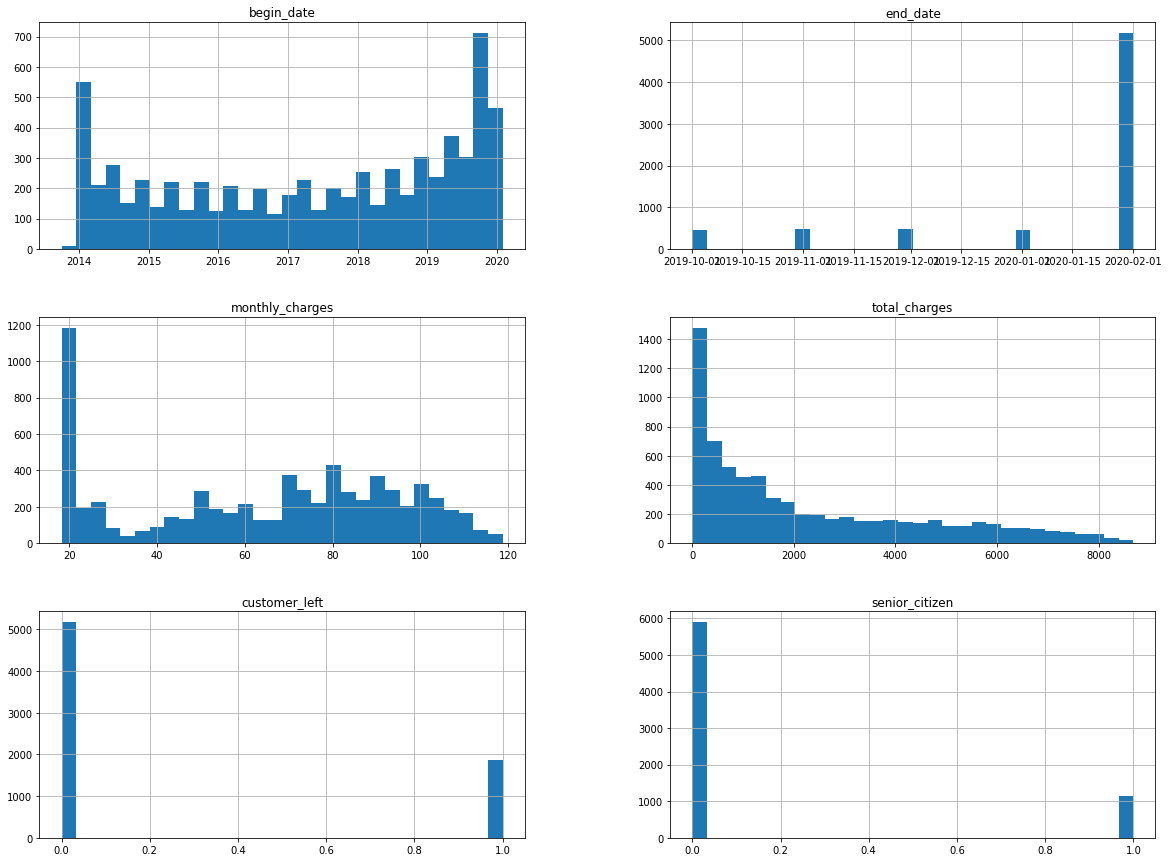

In [28]:
plot_and_describe(df.drop(columns = 'customer_id'))

Отметим дискретность дат завершения контракта: посмотрим на них попристальнее.

In [29]:
df.query('customer_left == 1')['end_date'].value_counts(normalize = True)

2019-11-01    0.259497
2019-12-01    0.249331
2020-01-01    0.246121
2019-10-01    0.245051
Name: end_date, dtype: float64

Все даты - первый день после окончания последних четырёх месяцев года.   
Две возможных интерпретации: либо что-то изменилось с условиями предоставления услуг, а до этого пользователи годами и помыслить не могли о расторжении, либо такую статистику стали вести только с конца сентября предыдущего года.  

Для исследования будем брать первую гипотезу: у нас нет достоверных способов подтвердить вторую, поэтому она отвергается.

Из интереса взглянем, как меняются данные по классам: ушедшие и оставшиеся. Разнится ли их распределение?

Stats for categorial


'type'

Month-to-month    0.885500
One year          0.088818
Two year          0.025682
Name: type, dtype: float64

'paperless_billing'

Yes    0.749064
No     0.250936
Name: paperless_billing, dtype: float64

'payment_method'

Electronic check             0.573034
Mailed check                 0.164794
Bank transfer (automatic)    0.138042
Credit card (automatic)      0.124131
Name: payment_method, dtype: float64

'gender'

Female    0.502408
Male      0.497592
Name: gender, dtype: float64

'partner'

No     0.642055
Yes    0.357945
Name: partner, dtype: float64

'dependents'

No     0.825575
Yes    0.174425
Name: dependents, dtype: float64

'multiple_lines'

Yes    0.454789
No     0.454254
N/a    0.090958
Name: multiple_lines, dtype: float64

'phone_user'

Yes    0.909042
No     0.090958
Name: phone_user, dtype: float64

'internet_service'

Fiber optic    0.693954
DSL            0.245586
Not a user     0.060460
Name: internet_service, dtype: float64

'online_security'

No     0.781701
Yes    0.157838
N/a    0.060460
Name: online_security, dtype: float64

'online_backup'

No     0.659711
Yes    0.279829
N/a    0.060460
Name: online_backup, dtype: float64

'device_protection'

No     0.64794
Yes    0.29160
N/a    0.06046
Name: device_protection, dtype: float64

'tech_support'

No     0.773676
Yes    0.165864
N/a    0.060460
Name: tech_support, dtype: float64

'streaming_tv'

No     0.504013
Yes    0.435527
N/a    0.060460
Name: streaming_tv, dtype: float64

'streaming_movies'

No     0.501873
Yes    0.437667
N/a    0.060460
Name: streaming_movies, dtype: float64

Stats:


,monthly_charges,total_charges,senior_citizen
count,1869.000000,1869.000000,1869.000000
mean,74.441332,1531.796094,0.254682
std,24.666053,1890.822994,0.435799
min,18.850000,18.850000,0.000000
25%,56.150000,134.500000,0.000000
50%,79.650000,703.550000,0.000000
75%,94.200000,2331.300000,1.000000
max,118.350000,8684.800000,1.000000


Plots:


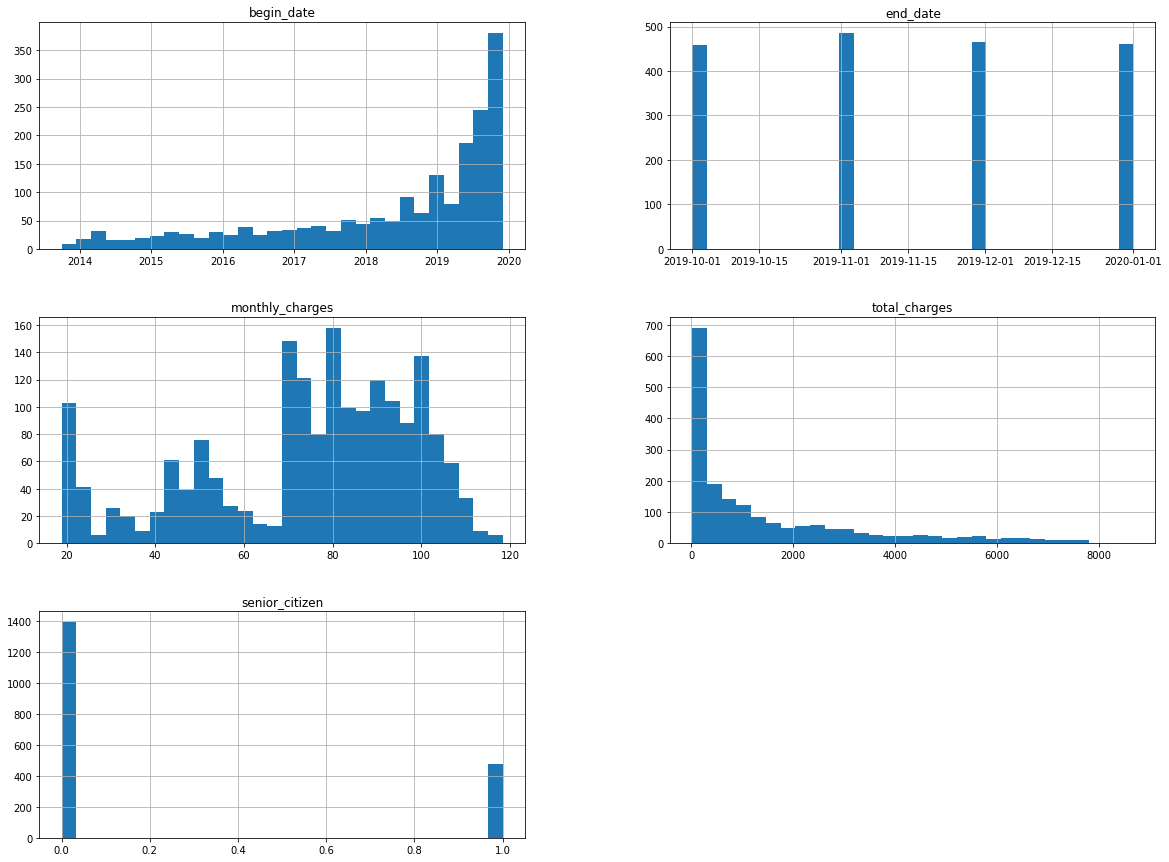

In [30]:
plot_and_describe(df.query('customer_left == 1').drop(columns=['customer_left','customer_id']))

Наблюдения:

- Уходят в основном относительно новые пользователи: среди ушедших их доля высока. 
- Среди ушедших выше доля на month-to-month контрактах. Это объяснимо лёгкостью выхода из такого соглашения, это логично.
- Почти все ушедшие пользуются интернетом. Возможно, при подготовке "не-уходи-от-нас"-пакета нужно обратить на это внимание.

Stats for categorial


'type'

Month-to-month    0.429068
Two year          0.318322
One year          0.252609
Name: type, dtype: float64

'paperless_billing'

Yes    0.535562
No     0.464438
Name: paperless_billing, dtype: float64

'payment_method'

Mailed check                 0.252029
Electronic check             0.250097
Credit card (automatic)      0.249324
Bank transfer (automatic)    0.248550
Name: payment_method, dtype: float64

'gender'

Male      0.507344
Female    0.492656
Name: gender, dtype: float64

'partner'

Yes    0.528218
No     0.471782
Name: partner, dtype: float64

'dependents'

No     0.655199
Yes    0.344801
Name: dependents, dtype: float64

'multiple_lines'

No     0.491109
Yes    0.409934
N/a    0.098956
Name: multiple_lines, dtype: float64

'phone_user'

Yes    0.901044
No     0.098956
Name: phone_user, dtype: float64

'internet_service'

DSL            0.379204
Fiber optic    0.347700
Not a user     0.273096
Name: internet_service, dtype: float64

'online_security'

No     0.393699
Yes    0.333204
N/a    0.273096
Name: online_security, dtype: float64

'online_backup'

Yes    0.368380
No     0.358523
N/a    0.273096
Name: online_backup, dtype: float64

'device_protection'

No     0.364128
Yes    0.362775
N/a    0.273096
Name: device_protection, dtype: float64

'tech_support'

No     0.391767
Yes    0.335137
N/a    0.273096
Name: tech_support, dtype: float64

'streaming_tv'

Yes    0.365868
No     0.361036
N/a    0.273096
Name: streaming_tv, dtype: float64

'streaming_movies'

Yes    0.369927
No     0.356977
N/a    0.273096
Name: streaming_movies, dtype: float64

Stats:


,monthly_charges,total_charges,senior_citizen
count,5174.000000,5174.000000,5174.000000
mean,61.265124,2549.911442,0.128721
std,31.092648,2329.954215,0.334923
min,18.250000,0.000000,0.000000
25%,25.100000,572.900000,0.000000
50%,64.425000,1679.525000,0.000000
75%,88.400000,4262.850000,0.000000
max,118.750000,8672.450000,1.000000


Plots:


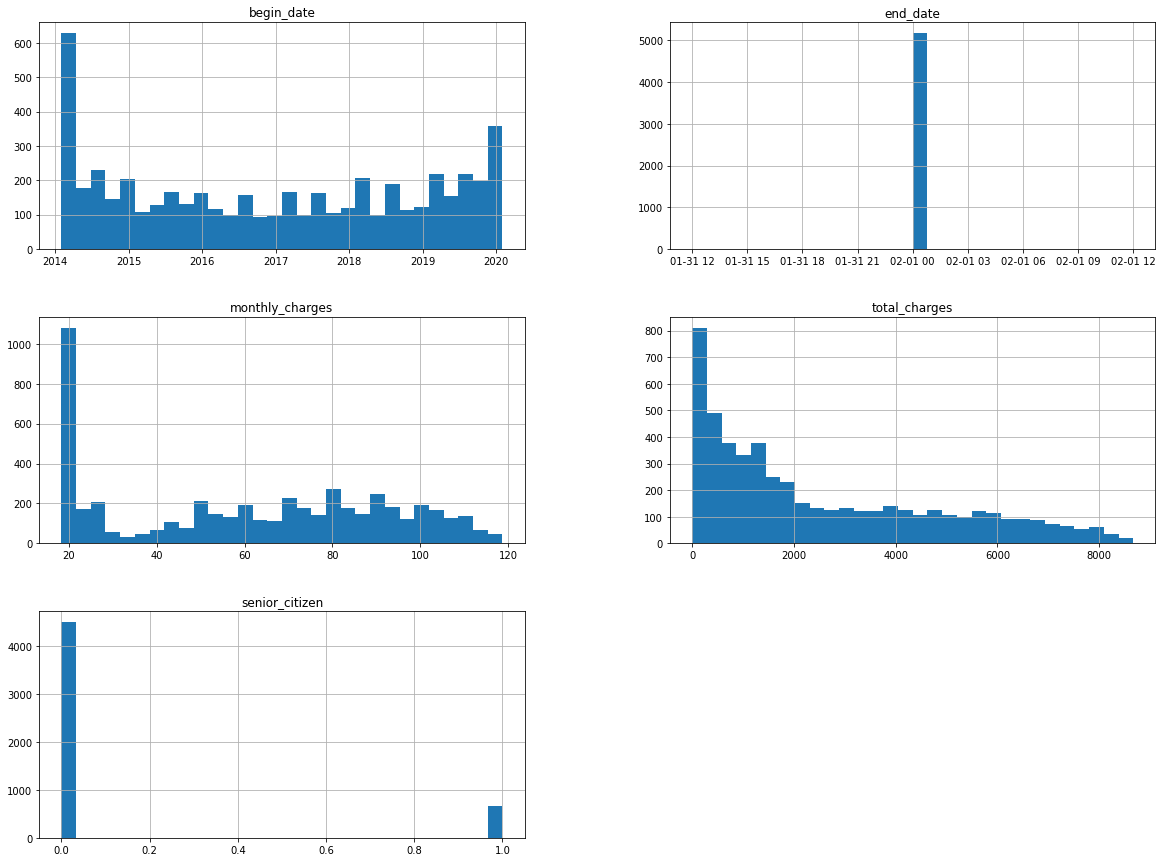

In [31]:
plot_and_describe(df.query('customer_left == 0').drop(columns=['customer_left','customer_id']))

Наблюдения:

- Больше половины из тех, кто не ушёл, на длительных контрактах. Предположительно, при подготовке предложения для склонных к уходу, стоит рассмотреть возможность предложения им длительного контракта на более выгодных условиях.
- 27% из неушедших пользователей не пользуются интернетом. Получается, среди непользователей интернета лояльность выше. Получается, следует обратить внимание на условия предоставления услуги или её качество.
- Неушедшие чаще пользуются стриминг-сервисами. Также следует рассмотреть их как часть компенсационного пакета.
- Соотношение Fiber optic/DSL у неушедших ниже: стоит рассмотреть гипотезу, что дело именно в оптоволоконной услуге.

Из столбцов с датами сделаем единый признак - длительность контракта в месяцах. 

In [32]:
df['contract_duration'] = (df['end_date'] - df['begin_date']).dt.days
df['contract_duration'].head()

0      31
1    1036
2      61
3    1371
4      61
Name: contract_duration, dtype: int64

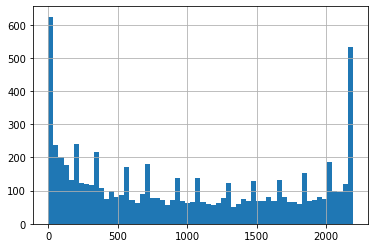

In [33]:
df['contract_duration'].hist(grid=True, bins = 60);

Видим приток новых пользователей, видим большое количество старых пользователей. Уберём столбцы с датами.

In [34]:
df = df.drop(columns = df.select_dtypes(include = 'datetime').columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   float64
 6   customer_left      7043 non-null   int64  
 7   gender             7043 non-null   object 
 8   senior_citizen     7043 non-null   int64  
 9   partner            7043 non-null   object 
 10  dependents         7043 non-null   object 
 11  multiple_lines     7043 non-null   object 
 12  phone_user         7043 non-null   object 
 13  internet_service   7043 non-null   object 
 14  online_security    7043 non-null   object 
 15  online_backup      7043 non-null   object 
 16  device_protection  7043 

<div class="alert alert-success">
<b>**Комментарий тимлида ✔️:**</b>

Отлино что удаляешь неинформативные и спорные признаки - 'customerID','EndDate', 'BeginDate'. Касаемо дат - у нас бинарная классификация а не анализ временных рядов. Кроме этого даты могут дать серьезную утечку целевого признака (помогать предсказывать модели правильный ответ)
</div>

Воспользуемся средствами библиотеки phi_k и посмотрим, как наши признаки коррелируют c целевым. Для этого сделаем список непрерывных переменных.

In [35]:
interval_cols = df.select_dtypes(include = 'float').columns.tolist()
interval_cols

['monthly_charges', 'total_charges']

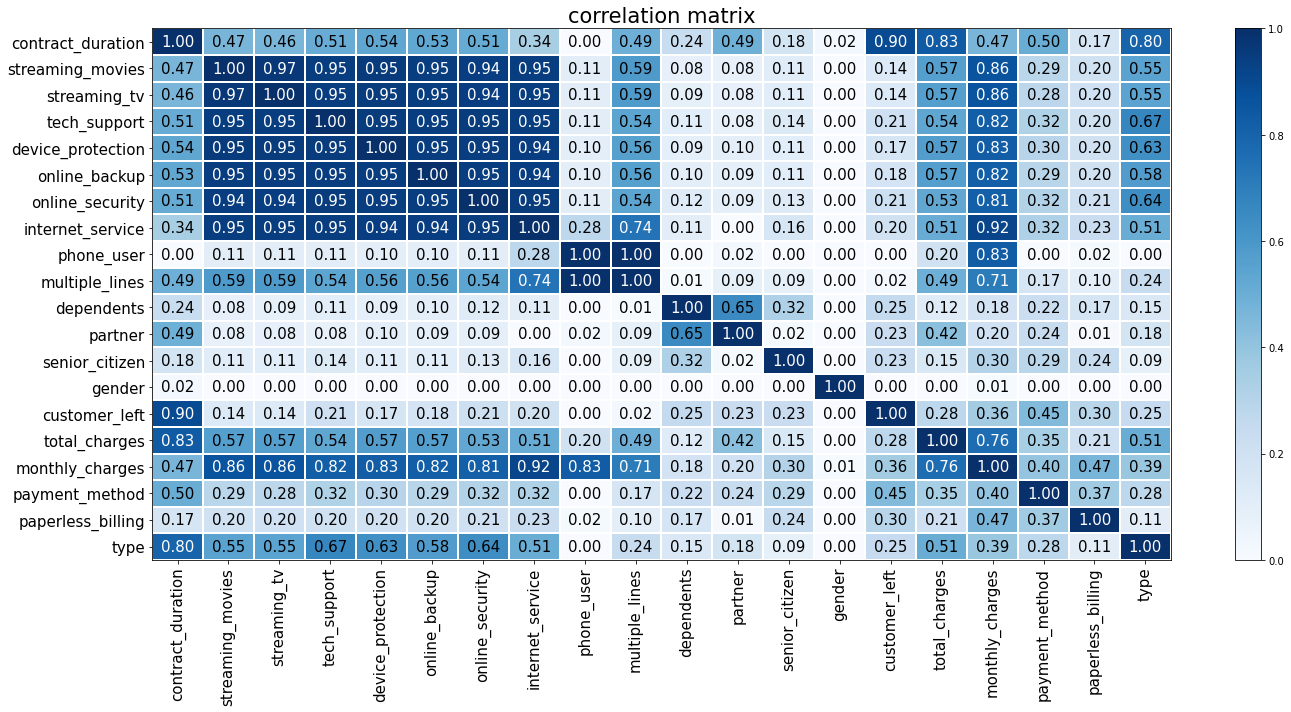

In [36]:
corr = df.drop(columns = 'customer_id').phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(corr.values, x_labels=corr.columns, y_labels=corr.index, 
                        vmin=0, vmax=1, color_map='Blues', title='correlation matrix', fontsize_factor=1.5,
                        figsize=(20,10))

Наблюдения:

- С полом клиента/клиентки не коррелирует ничего - убираем.  
- Поле phone_user не коррелирует с целевым признаком - убираем.
- Сильная корреляция между total charges и длительностью контракта естественна: чем дольше клиент остаётся клиентом, тем больше он суммарно потратит.
- Сильная корреляция между monthly_charges и набором услуг у клиента тоже логична: его ежемесячный счёт зависит от набора услуг. 
Отбросим лишние признаки и посмотрим на матрицу корреляции без них. Monthly_charges оставим.

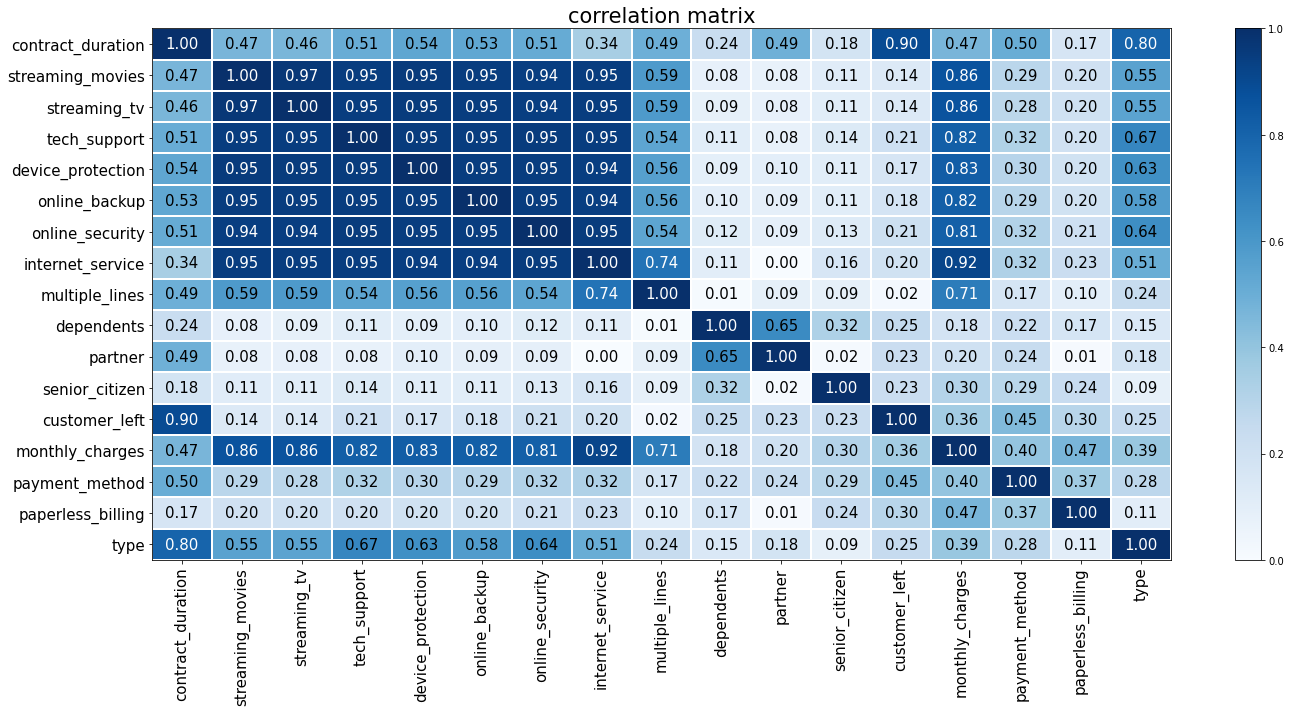

In [37]:
drop_list = ['customer_id','gender', 'total_charges', 'phone_user']
corr2 = df.drop(columns = drop_list).phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(corr2.values, x_labels=corr2.columns, y_labels=corr2.index, 
                        vmin=0, vmax=1, color_map='Blues', title='correlation matrix', fontsize_factor=1.5,
                        figsize=(20,10))

### Выводы

- Исходные таблицы были подготовлены к объединению: 
  - Устранены скрытые пропуски.
  - Столбцы приведены к корректным типам данных.
- Таблицы были объедиенены в мастер-датафрейм, устранены возникшие из-за объединения пропуски.
- Проведён исследовательский анализ данных, обнаружена аномалия в датах окончания контрактов.
- Определён наиболее несбалансированный признак - 'senior_citizen'. Это легко объясняется тем, что зачастую услуги связи своих пожилых родственников оплачивают молодые.
- Подготовлены синтетические признаки (длительность контракта).
- Проведён корреляционный анализ, определены избыточные для модели признаки.
- В качестве меры качества классификации будем использовать AUC-ROC: она позволяет оценить качество моделей вне зависимости от порога вероятности, при которой модель относить ту или иную запись к одному из двух классов. Таргет - **0.85+**

## Подготовка признаков

Для начала выделим все признанные нами важными признаки в один датафрейм.

In [38]:
df_pre_split = df.drop(columns = drop_list)
df_pre_split.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   customer_left      7043 non-null   int64  
 5   senior_citizen     7043 non-null   int64  
 6   partner            7043 non-null   object 
 7   dependents         7043 non-null   object 
 8   multiple_lines     7043 non-null   object 
 9   internet_service   7043 non-null   object 
 10  online_security    7043 non-null   object 
 11  online_backup      7043 non-null   object 
 12  device_protection  7043 non-null   object 
 13  tech_support       7043 non-null   object 
 14  streaming_tv       7043 non-null   object 
 15  streaming_movies   7043 non-null   object 
 16  contract_duration  7043 

In [39]:
df_pre_split.duplicated().sum()

48

In [40]:
df_pre_split.drop_duplicates(inplace = True)
df_pre_split.reset_index(drop=True).duplicated().sum()

0

Разделим данные на тренировочную и тестовую выборки.

In [41]:
features_train, features_test, target_train, target_test = train_test_split(df_pre_split.\
                                                                            drop(columns = 'customer_left'),
                                                                            df_pre_split['customer_left'],     
                                                                            test_size=0.25,
                                                                            random_state=STATE, 
                                                                            stratify= df_pre_split['customer_left']
                                                                           )

Теперь закодируем категориальные признаки, для выбора метода кодировки оценим количество уникальных значений в каждом из столбцов.

In [42]:
categorial = features_train.select_dtypes(include='object').columns
for column in categorial:
    print(f'Уникальных значений в столбце {column}: {len(df_pre_split[column].unique())}')

Уникальных значений в столбце type: 3
Уникальных значений в столбце paperless_billing: 2
Уникальных значений в столбце payment_method: 4
Уникальных значений в столбце partner: 2
Уникальных значений в столбце dependents: 2
Уникальных значений в столбце multiple_lines: 3
Уникальных значений в столбце internet_service: 3
Уникальных значений в столбце online_security: 3
Уникальных значений в столбце online_backup: 3
Уникальных значений в столбце device_protection: 3
Уникальных значений в столбце tech_support: 3
Уникальных значений в столбце streaming_tv: 3
Уникальных значений в столбце streaming_movies: 3


С таким небольшим количеством уникальных значений использование простого OHE не создаст избыточного количества столбцов и не замедлит работу моделей. Можно не прибегать к binary encoder.
Кодировку признаков будем проводить непосредственно при обучении каждой из выбранных моделей.

In [43]:
OHE = OneHotEncoder(drop = 'first', handle_unknown='ignore')
ORD = OrdinalEncoder ()

На всякий случай перепроверим размеры выборок:

In [44]:
sample_list = ['train','test']
split_list = ['features', 'target']

for sample in sample_list:
    for split in split_list:
        print (f'Length of {split}_{sample}:', len(eval(''.join([split,'_',sample]))),'\n')

Length of features_train: 5246 

Length of target_train: 5246 

Length of features_test: 1749 

Length of target_test: 1749 



Создадим два преобразователя колонок: первый - для линейных моделей, второй - для моделей на основе деревьев решений.

In [45]:
log_trans = make_column_transformer(
    (OHE, make_column_selector(dtype_include=object)),
    remainder=StandardScaler())

tree_trans = make_column_transformer(
    (ORD, make_column_selector(dtype_include=object)),
    remainder='passthrough')

### Вывод:
- Признаки подготовлены: категориальные признаки закодированы, числовые признаки масштабированы.

### Подготовка рабочих функций

Для начала, напишем функцию построения ROC-AUC кривой и подсчёта площади под ней. Для этого сначала отдельно зададим кросс-валидатор.

In [46]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = STATE)

Теперь напишем саму функцию построения кривой и вывода метрики.

In [47]:
def auc_roc_curve_plot (model, features, target):
    proba = cross_val_predict(model, features, target, cv=cv, method='predict_proba')
    probabilities_one_valid = proba[:, 1]
    fpr, tpr, thresholds = roc_curve(target, probabilities_one_valid)
    plt.figure()
    plt.plot(fpr,tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')# - ROC-curve
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel ("True Positive Rate")
    plt.title ('ROC-curve')
    plt.figtext (s = f"AUC-ROC = {roc_auc_score(target, probabilities_one_valid):,.4}",\
                 x = 0.5, y = 0.2)
    plt.show()

При подборе гиперпараметров будем использовать BayesSearchCV - быстрее, чем HalvingGridSearch, умнее, чем RandomSearch. Добавим callback для ранней остановки.  

Порогом остановки выберем 0.002.

In [48]:
callback = DeltaYStopper(delta=0.002)  

Теперь время для основной функции - она будет в один вызов обучать модель и сохранять её саму, её параметры и результаты.

In [49]:
def gridsearch_save(model, parameters, features = features_train,target = target_train):
    grid = BayesSearchCV(model, parameters, 
                         scoring = 'roc_auc', cv = cv, verbose = 3, n_iter = 25)
    
    grid.fit(features, target, callback = callback)
    
    auc_roc_curve_plot (grid.best_estimator_, features, target)
    
    print()
    print (f"Для выбранной модели наилучший результат = {grid.best_score_:0.3f}")
    model_dict = {'score':grid.best_score_,
                  'fit_time':grid.refit_time_,
                  'params':grid.best_params_,
                  'model':grid.best_estimator_}
    return model_dict

### Обучение моделей

Основной упор сделаем на ансамблевые модели, но для начала попробуем линейную модель со стохастическим градиентным спуском.

In [50]:
sgd_pipe = Pipeline(steps=[("encoder", log_trans), ("model", SGDClassifier(loss = 'modified_huber',
                                                                              random_state = STATE,
                                                                              penalty = 'elasticnet'
                                                                             ))])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ................model__alpha=0.085;, score=0.817 total time=   0.1s
[CV 2/5] END ................model__alpha=0.085;, score=0.847 total time=   0.2s
[CV 3/5] END ................model__alpha=0.085;, score=0.828 total time=   0.2s
[CV 4/5] END ................model__alpha=0.085;, score=0.822 total time=   0.2s
[CV 5/5] END ................model__alpha=0.085;, score=0.844 total time=   0.2s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ...model__alpha=0.8350000000000001;, score=0.811 total time=   0.2s
[CV 2/5] END ...model__alpha=0.8350000000000001;, score=0.832 total time=   0.2s
[CV 3/5] END ...model__alpha=0.8350000000000001;, score=0.820 total time=   0.1s
[CV 4/5] END ...model__alpha=0.8350000000000001;, score=0.805 total time=   0.2s
[CV 5/5] END ...model__alpha=0.8350000000000001;, score=0.836 total time=   0.2s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END 

/opt/conda/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ................model__alpha=0.085;, score=0.817 total time=   0.2s
[CV 2/5] END ................model__alpha=0.085;, score=0.847 total time=   0.2s
[CV 3/5] END ................model__alpha=0.085;, score=0.828 total time=   0.2s
[CV 4/5] END ................model__alpha=0.085;, score=0.822 total time=   0.2s
[CV 5/5] END ................model__alpha=0.085;, score=0.844 total time=   0.2s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END .................model__alpha=0.11;, score=0.817 total time=   0.2s
[CV 2/5] END .................model__alpha=0.11;, score=0.845 total time=   0.2s
[CV 3/5] END .................model__alpha=0.11;, score=0.829 total time=   0.2s
[CV 4/5] END .................model__alpha=0.11;, score=0.822 total time=   0.2s
[CV 5/5] END .................model__alpha=0.11;, score=0.843 total time=   0.2s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END 

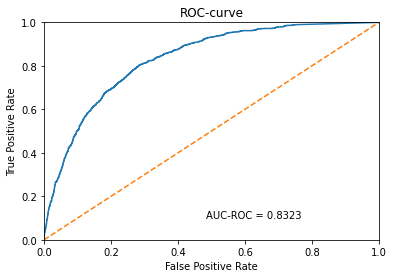


Для выбранной модели наилучший результат = 0.833


In [51]:
model = sgd_pipe

parameters = {'model__alpha': np.arange(0.01, 1.0, 0.025)
             }

sgd_pipe_dict = gridsearch_save(model, parameters)

Далее построим модель случайного леса. 

In [52]:
forest_pipe = Pipeline(steps=[("encoder", tree_trans), ("model", RandomForestClassifier(random_state = STATE))])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END model__max_depth=10, model__n_estimators=200;, score=0.835 total time=   0.9s
[CV 2/5] END model__max_depth=10, model__n_estimators=200;, score=0.864 total time=   0.9s
[CV 3/5] END model__max_depth=10, model__n_estimators=200;, score=0.844 total time=   0.9s
[CV 4/5] END model__max_depth=10, model__n_estimators=200;, score=0.852 total time=   0.9s
[CV 5/5] END model__max_depth=10, model__n_estimators=200;, score=0.852 total time=   0.9s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END model__max_depth=8, model__n_estimators=310;, score=0.837 total time=   1.3s
[CV 2/5] END model__max_depth=8, model__n_estimators=310;, score=0.868 total time=   1.2s
[CV 3/5] END model__max_depth=8, model__n_estimators=310;, score=0.849 total time=   1.3s
[CV 4/5] END model__max_depth=8, model__n_estimators=310;, score=0.854 total time=   1.2s
[CV 5/5] END model__max_depth=8, model__n_estimators=310;, score=0.

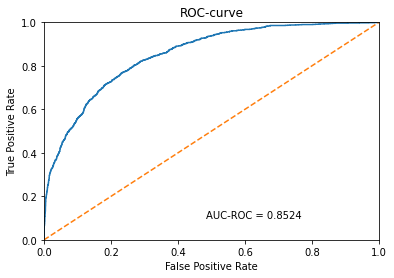


Для выбранной модели наилучший результат = 0.853


In [53]:
model = forest_pipe

parameters = {'model__n_estimators': [*range(50,351,10)],
             'model__max_depth': [*range (8,22,2)]
             }

forest_dict = gridsearch_save(model, parameters)

Теперь построим несколько бустинговых классфикационных моделей. Решил остановиться на двух - GradientBoostingClassifier из пакета scikit-learn и CatBoost.

In [54]:
sklearn_gb_pipe = Pipeline(steps=[("encoder", tree_trans), ("model", GradientBoostingClassifier(random_state = STATE))])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END model__learning_rate=0.05, model__max_depth=12, model__min_samples_leaf=40, model__n_estimators=750;, score=0.881 total time=  10.8s
[CV 2/5] END model__learning_rate=0.05, model__max_depth=12, model__min_samples_leaf=40, model__n_estimators=750;, score=0.900 total time=  11.0s
[CV 3/5] END model__learning_rate=0.05, model__max_depth=12, model__min_samples_leaf=40, model__n_estimators=750;, score=0.888 total time=  10.8s
[CV 4/5] END model__learning_rate=0.05, model__max_depth=12, model__min_samples_leaf=40, model__n_estimators=750;, score=0.880 total time=  11.1s
[CV 5/5] END model__learning_rate=0.05, model__max_depth=12, model__min_samples_leaf=40, model__n_estimators=750;, score=0.901 total time=  11.2s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END model__learning_rate=0.1, model__max_depth=18, model__min_samples_leaf=30, model__n_estimators=100;, score=0.878 total time=   1.9s
[CV 2/5

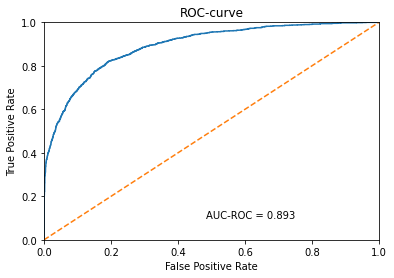


Для выбранной модели наилучший результат = 0.893
CPU times: user 14min 18s, sys: 14.8 s, total: 14min 33s
Wall time: 14min 36s


In [55]:
%%time

model = sklearn_gb_pipe

parameters =  {'model__learning_rate':[0.15,0.1,0.05,0.01], 
               'model__n_estimators':[100,250,500,750,1000],
               'model__min_samples_leaf':[*range(20,51,10)],
               'model__max_depth': [*range (8,22,2), None]
              }

sklearn_gb_dict = gridsearch_save(model, parameters)

С CatBoost не будем сочетать отдельный кодировщик: попробуем довериться встроенному в модель OHE. Эксплицитно укажем столбцы для трансформации.

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END learning_rate=0.1, min_child_samples=70, n_estimators=350;, score=0.894 total time=   6.4s
[CV 2/5] END learning_rate=0.1, min_child_samples=70, n_estimators=350;, score=0.909 total time=   7.3s
[CV 3/5] END learning_rate=0.1, min_child_samples=70, n_estimators=350;, score=0.900 total time=   6.8s
[CV 4/5] END learning_rate=0.1, min_child_samples=70, n_estimators=350;, score=0.897 total time=   5.9s
[CV 5/5] END learning_rate=0.1, min_child_samples=70, n_estimators=350;, score=0.910 total time=   6.7s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END learning_rate=0.1, min_child_samples=90, n_estimators=600;, score=0.899 total time=  10.1s
[CV 2/5] END learning_rate=0.1, min_child_samples=90, n_estimators=600;, score=0.915 total time=  10.0s
[CV 3/5] END learning_rate=0.1, min_child_samples=90, n_estimators=600;, score=0.902 total time=   9.9s
[CV 4/5] END learning_rate=0.1, min_child_samples=

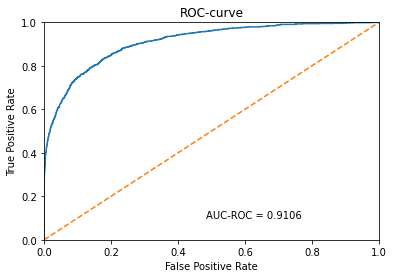


Для выбранной модели наилучший результат = 0.911
CPU times: user 15min 41s, sys: 37.3 s, total: 16min 18s
Wall time: 19min 40s


In [56]:
%%time 

model = CatBoostClassifier(eval_metric = 'AUC', verbose = 0, random_state = STATE, 
                           cat_features = features_train.select_dtypes(include=object).columns.tolist())

parameters =  {'learning_rate':[0.15,0.1,0.05,0.01],
              'n_estimators':[*range(100,1001,250)],
              'min_child_samples':[*range(20,101,10)]
              }

catboost_dict = gridsearch_save(model, parameters)

Выведем результаты и скорость обучения всех моделей в виде таблички.

In [75]:
dict_list = [sgd_pipe_dict, forest_dict, sklearn_gb_dict, catboost_dict]

model_scores = pd.DataFrame(dict_list, index = ['sgd_pipe','forest', 'sklearn_gb', 'catboost']).drop(columns=['params','model'])\
.sort_values(by='score', ascending = False)
model_scores

,score,fit_time
catboost,0.910784,12.339178
sklearn_gb,0.893223,16.211408
forest,0.852967,1.351515
sgd_pipe,0.833119,0.139541


Сейчас мы выбирали модели исходя из ROC-AUC, но стоит взглянуть и на другие метрики наших моделей.

In [76]:
metrics_dict = {}
for model in model_scores.index.tolist():
    predict = eval("_".join([model, "dict['model']"])).predict(features_train)
    metrics_dict[model] = classification_report(target_train, predict,\
                                              target_names=['stayed', 'left'], output_dict=True)
    
metrics = pd.DataFrame(metrics_dict).transpose()\
.rename(columns = {'stayed':'f1-score','left':'recall','macro avg':'precision'})\
.drop(columns=['weighted avg'])

for model in metrics.index:
    for metric in ['f1-score','recall', 'precision']:
        metrics.loc[model][metric] = metrics_dict[model]['left'][metric]

model_scores = pd.merge(model_scores, metrics, left_index = True, right_index = True)
model_scores

,score,fit_time,f1-score,recall,accuracy,precision
catboost,0.910784,12.339178,0.880637,0.83537,0.939954,0.93109
sklearn_gb,0.893223,16.211408,0.993865,0.989935,0.996759,0.997826
forest,0.852967,1.351515,0.646128,0.557872,0.837972,0.767557
sgd_pipe,0.833119,0.139541,0.562397,0.492451,0.796798,0.655502


У модели CatBoost самая высокая метрика ROC-AUC: это показывает, что несмотря на более высокие accuracy и recall у sklearnGB, она точнее предсказывает вероятности классов: скорее всего, sklearnGB просто переобучилась.

Метрику Recall возможно увеличить с помощью изменения threshold. Метрика AUC-ROC в таком случае не изменится: threshold меняет интерпретацию вероятности отнесения к тому или иному классу, а AUC-ROC основана на самих вероятностях. 

Recall = 1 легко получить, если поставить порог разнесения по классам = 0, поэтому наложим дополнительное условие: общая адекватность модели должна быть незначительно хуже максимума.

Метрику Recall (которая показывает, насколько полно модель предсказывает интересующий класс) возможно увеличить с помощью изменения threshold. Метрика AUC-ROC в таком случае не изменится: threshold меняет интерпретацию вероятности отнесения к тому или иному классу.

In [130]:
def threshold_select (model, features, target):
    proba = cross_val_predict(model, features, target, cv=cv, method='predict_proba')
    probabilities_one_valid = proba[:, 1]
    
    thresholds = list((np.arange(0, 1.01, 0.02)))
    thresholds.reverse()
    
    f1_best = 0
    f1_recall_dict = {}
    
    for threshold in tqdm(thresholds):
        predicted_valid = probabilities_one_valid > threshold
        recall = recall_score (target, predicted_valid)
        f1 = f1_score(target, predicted_valid)
        f1_recall_dict[threshold] = (f1,recall)
        if f1 > f1_best:
            f1_best = f1
            
    threshold_best = 0        
    recall_optimum = 0
    
    for threshold in tqdm(thresholds):
        if f1_best - f1_recall_dict[threshold][0] < 0.005 and f1_recall_dict[threshold][1] > recall_optimum:
            recall_optimum = f1_recall_dict[threshold][1]
            threshold_best = threshold
            
    print(f"Optimal threshold = {threshold_best}")
    
    return threshold_best

In [131]:
catboost_dict['model'].set_probability_threshold(binclass_probability_threshold =\
                                                 threshold_select (catboost_dict['model'],\
                                                                   features_train, target_train))
predict = catboost_dict['model'].predict(features_train)
update = classification_report(target_train, predict, target_names=['stayed', 'left'], output_dict=True)

for metric in ['f1-score','recall', 'precision']:
        model_scores.loc['catboost', metric] = update['left'][metric]
        
model_scores.loc['catboost', 'accuracy'] = update['accuracy']

model_scores

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Optimal threshold = 0.32


,score,fit_time,f1-score,recall,accuracy,precision
catboost,0.910784,12.339178,0.878148,0.92739,0.931758,0.833872
sklearn_gb,0.893223,16.211408,0.993865,0.989935,0.996759,0.997826
forest,0.852967,1.351515,0.646128,0.557872,0.837972,0.767557
sgd_pipe,0.833119,0.139541,0.562397,0.492451,0.796798,0.655502


Общая точность модели упала незначительно, Recall заметно вырос.

### Вывод:

Модели обучены, наилучший результат на кросс-валидации показала модель CatBoost, у модели оптимизирован порог разнесения по классам.

### Тестирование модели

Проверим, как наша модель работает на тестовой выборке.

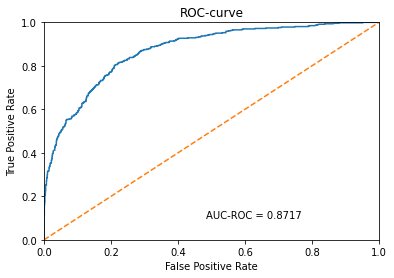

,stayed,left,accuracy,macro avg,weighted avg
precision,0.927994,0.730994,0.870212,0.829494,0.875731
recall,0.892607,0.808190,0.870212,0.850398,0.870212
f1-score,0.909956,0.767656,0.870212,0.838806,0.872205
support,1285.000000,464.000000,0.870212,1749.000000,1749.000000


In [124]:
best_model = eval(model_scores.index.tolist()[0]+"_dict['model']")
auc_roc_curve_plot(best_model, features_test, target_test)
predict = best_model.predict(features_test)
display(pd.DataFrame(classification_report(target_test, predict,\
                                              target_names=['stayed', 'left'], output_dict=True)))

Посмотрим, какие признаки модель сочла наиболее важными.

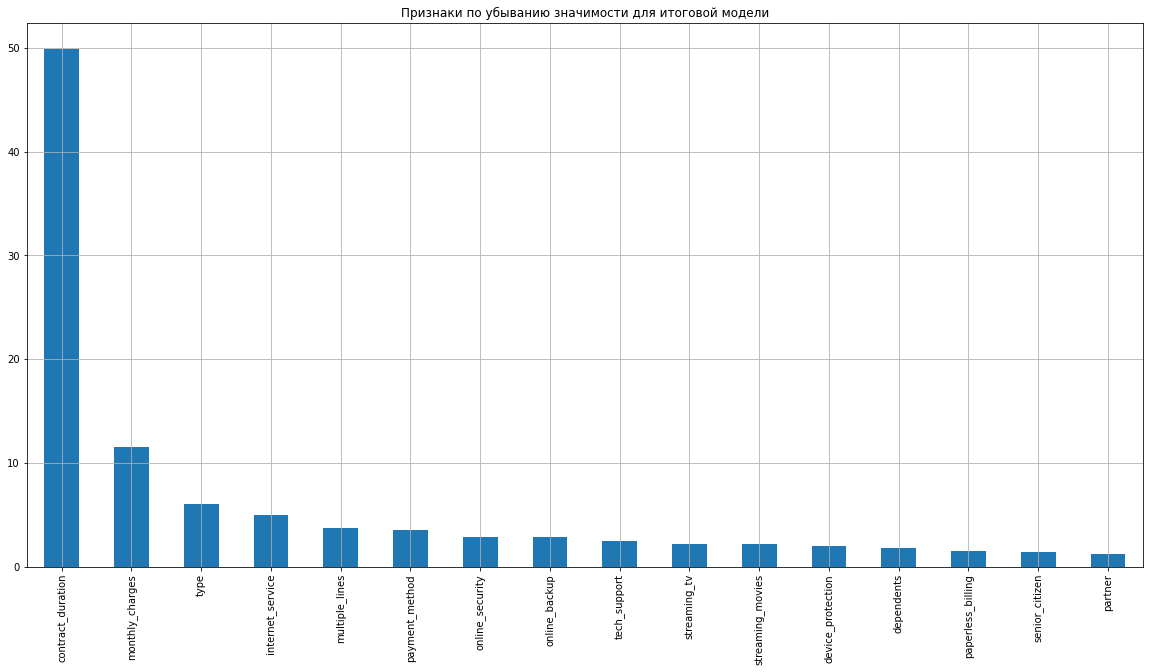

In [127]:
pd.Series(best_model.feature_importances_, index=features_test.columns).sort_values(ascending=False)\
.plot(kind = 'bar', grid = True, title = 'Признаки по убыванию значимости для итоговой модели', figsize = (20,10));

Выведем на экран итоговые гиперпараметры модели.

In [128]:
best_model.get_params()

{'learning_rate': 0.15,
 'verbose': 0,
 'eval_metric': 'AUC',
 'n_estimators': 600,
 'random_state': 70423,
 'cat_features': ['type',
  'paperless_billing',
  'payment_method',
  'partner',
  'dependents',
  'multiple_lines',
  'internet_service',
  'online_security',
  'online_backup',
  'device_protection',
  'tech_support',
  'streaming_tv',
  'streaming_movies'],
 'min_child_samples': 40}

### Выводы:

Выбранная модель (CatBoost) показала необходимый уровень точности.  

По остальным метрикам можно сделать следующие наблюдения:  
- Исходная модель была склонна к ложноотрицательной ошибке (ошибочно сказать, что клиент не планирует уйти): recall (метрика, показывающая эту склонность) у ушедших абонентов была ниже precision. Это было исправлено с помощью оптимизации порог разнесения по классам. 
- Accuracy модели - 0.87: предсказание модели правильное в 87 случаях из ста.
- Recall модели - 0.81: в 81 случаях из ста модель верно определяет уходящего абонента, сохраняя при этом общую адекватность на приемлемом уровне: f1-score исходной модели и модели с изменённым порогом отличаются меньше, чем на две сотых.

Наиболее важные признаки для модели - длительность обслуживания абонента, ежемесячная сумма к оплате, тип контракта и тип интернет-подключения. 
Как мы могли заметить на этапе EDA, признак интернет-подключения разнится наиболее сильно между двумя классами: среди ушедших доля пользователей оптоволокна выше, чем среди оставшихся.  

Рекомендации:
- Следует максимизировать срок контракта и ежемесячный платёж: рассмотреть возможность пакетных предложений со скидками на побочные услуги (если ещё не осуществлено)
- Допустить возможность перевода абонента на долгосрочный контракт - также за скидку
- Обратить внимание на услугу оптоволоконного доступа в интернет, собрать информацию по причинам отказа, исследовать качество услуги

## Отчёт о проделанной работе

### Исходная задача: 
Была поставлена задача создать модель, наиболее точно предсказывающую, что пользователь планирует уйти. Модель будут использовать для определения, предлагать ли пользователю более выгодные условия, чтобы удержать его.

### Исходные данные
Данные хранились в нескольких .csv-таблицах с общим полем customerID - уникальным идентификатором клиента.

### Шаги исследования
- Исследовательский анализ данных и предобработка  
- Подготовка признаков
- Обучение и отбор модели
- Тестирование модели

### Summary:
**- Исследовательский анализ данных и предобработка:**
  * Оценена полнота данных, устранены пропуски, дубликаты не обнаружены
  * Столбцы были приведены к корректным типам данных (datetime для дат). Бинарные категориальные признаки было решено не кодировать вручную и не приводить к типу bool. 
  * Были определены наиболее значимые признаки - срок обслуживания клиента, способ оплаты, ежемесячная сумма затрат
  * Были сравнены показатели ушедших и оставшихся клиентов - наибольшие различия обнаружены в разрезе услуги оптоволоконного интернет-доступа.
  * Были удалены нерелеватнтные признаки:
    - Признаки, не обладающие корреляцией с другими признаками.
    - Признаки, обладавшие мультиколлинеарностью с другими признаками.
  * Ключевой метрикой для сравнения моделей была выбрана AUC-ROC ***>0.85***.          
  
  Эта метрика оценивает насколько точно модель предсказывает оба класса (остался/ушёл) и сравнивает обученную модель с константной моделью.   
  
  
  * В качестве дополнительной метрики выбрана recall, полнота.   
  
  При возможной оптимизации recall было принято решение опираться на достаточно высокий f1-score: эта метрика, как и AUC-ROC, показывает, насколько точно модель предсказывает оба класса, но в отличие от неё, зависит от порогового значения вероятности для отнесения к положительному классу, которое можно менять, чтобы изменить предпочтения и склонности модели. 
  
  
**- Подготовка признаков:**
  * Таблицы были объединены, образовавшиеся пропуски заполнены. 
  * Устранение дисбаланса выборки признано необязательным: соотношение ушедших и оставшихся 3:1.
  * Данные были разделены на тренировочную и тестовую выборки
  * Были созданы преобразователи признаков для разных моделей:
    - Стандартизация/нормализация числовых переменных и OHE-кодирование категориальных переменных для линейных моделей
    - Порядковое кодирование категориальных переменных для моделей на основе деревьев решений (случайный лес, градиентный бустинг)
  
  
**- Выбор модели:**
  * Для исследования были выбраны следующие модели:
      - Стохастический градиентный спуск
      - Случайный лес
      - Градиентный бустинг из библиотеки `scikit-learn`
      - Градиентный бустинг `CatBoost` с встроенным кодировщиком категориальных признаков
  * Для первых трёх моделей были созданы пайплайны с соответствующими типу модели преобразователями.
  * Модели были обучены с Байесовским подбором гиперпараметров на кросс-валидации (`skopt-BayesSeachCV`).  
  Был задан критерий ранней остановки подбора - когда разница между результатами лучшей на данный момент моделью и исследуемой составляла не более ***0.002*** (AUC-ROC меняется в диапазоне от 0 до 1). 
  * Модели были сравнены по результатам обучения на тестовой выборке по основной метрике. Была выбрана модель `CatBoost` с гиперпараметрами:  
  `learning_rate': 0.15, 
  'n_estimators': 600, 
  'min_child_samples': 40`  
  Итоговый AUC-ROC на тренировочной выборке = ***0.911***
  * Для увеличения вторичной метрики была произведена оптимизация порога разнесения по классам с ограничением на допустимую общую неточность. 
  Итоговый recall на тестовой выборке = ***0.927***
  
  Сравнение метрик моделей:
  
  <div>
    <img align = left src="https://i.ibb.co/6JdwyK1/2023-04-12-17-59-30.png" width="450"/>
  <br><br><br><br><br><br><br>
  </div>
  * Модель была проверена на тестовой выборке  
  Итоговый AUC-ROC на тренировочной выборке = ***0.872***  
  Итоговый recall на тестовой выборке = ***0.808***   
  Итоговая accuracy на тестовой выборке = ***0.870***   
  * Наиболее важные признаки для модели - длительность обслуживания абонента, ежемесячная сумма к оплате, тип контракта и тип интернет-подключения. 
  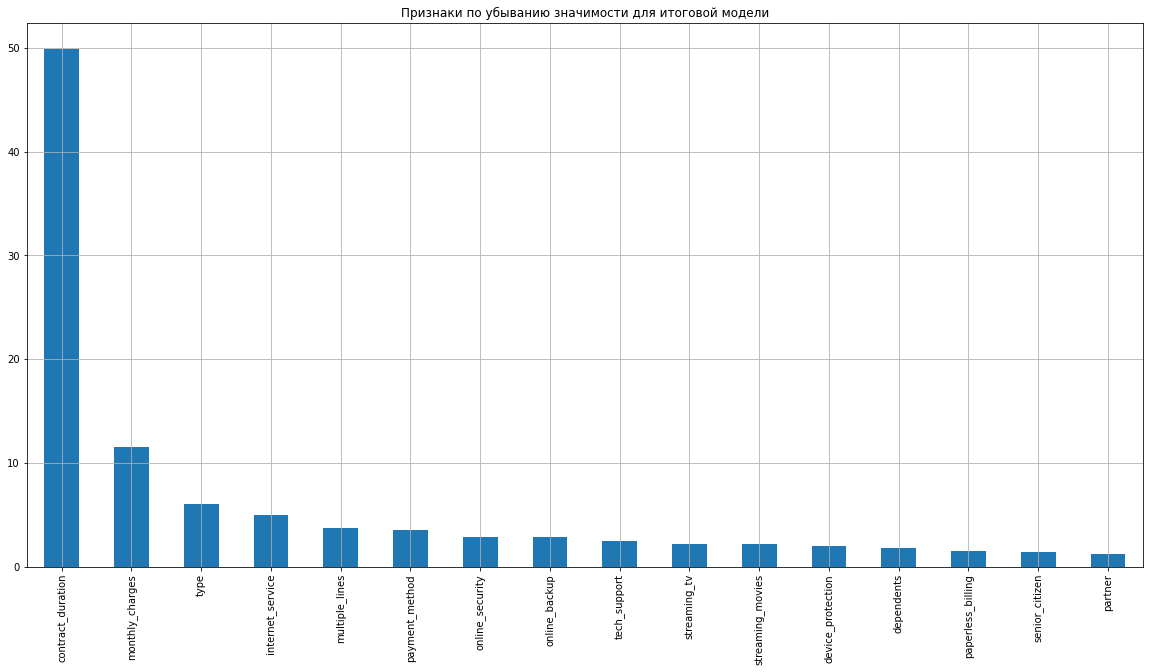  
  
  
 ### Трудности:
 - Использовать ли ресэмплинг? Отказался, модели переобучались и завышали метрики на тестовой выборке
 - Максимизация пространства гиперпараметров для моделей при сохранении относительного быстродействия
 - Отбор признаков: оставить ли хотя бы один из числовых признаков, или отказаться от обоих? Оставил один, более информативный из двух
 - Ручное кодирование бинарных признаков и приведение их к булевому типу или использование энкодеров? Использовал энкодеры, соответствующие моделям.
 
 